In [1]:
# Import thư viện cần thiết để làm việc với Google Drive trong Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import thư viện

In [2]:
import tensorflow as tf  # Thư viện xây dựng và huấn luyện mô hình học máy
from tensorflow.keras.preprocessing import image_dataset_from_directory  # Tạo dataset từ thư mục hình ảnh
from PIL import Image  # Thư viện xử lý hình ảnh
import cv2  # Thư viện xử lý hình ảnh và video
import matplotlib.pyplot as plt  # Thư viện hiển thị biểu đồ, hình ảnh
import numpy as np  # Thư viện tính toán trên mảng nhiều chiều
import os  # Thư viện thao tác với hệ thống file và thư mục

## Config một số tham số

In [7]:
batch_size = 16  # Số lượng mẫu được xử lý trong mỗi batch trong quá trình huấn luyện
input_size = 160  # Kích thước đầu vào của hình ảnh (160x160 pixels)
model_name = "mobilenet_V2"  # Tên của mô hình học máy sẽ được sử dụng (MobileNetV2)
initial_epochs = 100  # Số epoch ban đầu để huấn luyện mô hình
base_learning_rate = 0.001  # Tốc độ học (learning rate) của quá trình huấn luyện
train_dir = '/content/data/train/'  # Đường dẫn đến thư mục dữ liệu huấn luyện
validation_dir = test_dir = '/content/data/test/'  # Đường dẫn đến thư mục dữ liệu kiểm thử và validation

In [4]:
path_colab_drive = '/content/drive/MyDrive/289.Phan_loai_vet_thuong_ngoai_da' # Đường dẫn đến project

In [ ]:
!cp -R "{path_colab_drive}/data" /content/data/  # Sao chép toàn bộ thư mục "data" từ Google Drive sang thư mục /content/data/ trong Colab
!unzip /content/data/data.zip  # Giải nén file data.zip trong thư mục /content/data/
!rm /content/data/data.zip  # Xóa file data.zip sau khi đã giải nén

In [6]:
import os
import shutil
import random

# Thư mục gốc
data_dir = "/content/data"

# Tạo thư mục train và test trong data
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Duyệt qua từng class folder trong data (bỏ qua train/test)
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if not os.path.isdir(class_path) or class_name in ["train", "test"]:
        continue

    # Lấy danh sách ảnh
    images = os.listdir(class_path)
    random.shuffle(images)

    # Chia 80/20
    split_idx = int(0.8 * len(images))
    train_images = images[:split_idx]
    test_images = images[split_idx:]

    # Tạo thư mục class trong train và test
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    # Move ảnh vào train
    for img in train_images:
        shutil.move(os.path.join(class_path, img),
                    os.path.join(train_dir, class_name, img))

    # Move ảnh vào test
    for img in test_images:
        shutil.move(os.path.join(class_path, img),
                    os.path.join(test_dir, class_name, img))

    # Xoá folder class gốc cho gọn
    shutil.rmtree(class_path)

print("✅ Đã chia ảnh vào data/train và data/test")

✅ Đã chia ảnh vào data/train và data/test


# Xóa ảnh lỗi

In [8]:
count = 0  # Biến đếm số lượng tệp hình ảnh không hợp lệ đã bị xóa

# Danh sách các thư mục chứa dữ liệu huấn luyện và kiểm thử
list_foler = [train_dir, validation_dir]

# Lặp qua từng thư mục trong danh sách
for folder in list_foler:
    # Lặp qua từng thư mục con (class folders) trong thư mục hiện tại
    for class_folder in os.listdir(folder):
        folder_path = os.path.join(folder, class_folder)  # Tạo đường dẫn đến thư mục lớp
        flag_break = False  # Biến cờ không sử dụng trong đoạn code này
        # Lặp qua từng tệp hình ảnh trong thư mục lớp
        for img_file in os.listdir(folder_path):
            old_img_file_path = os.path.join(folder_path, img_file)  # Đường dẫn cũ của tệp hình ảnh
            filename, ext = os.path.splitext(img_file)  # Tách tên tệp và phần mở rộng
            new_img_file_path = os.path.join(folder_path, filename + '.jpg')  # Đường dẫn mới với phần mở rộng .jpg
            try:
                new_img = Image.open(old_img_file_path)  # Mở tệp hình ảnh cũ
                new_img.save(new_img_file_path, format="JPEG", quality=100)  # Lưu hình ảnh dưới định dạng JPEG với chất lượng cao
                if old_img_file_path != new_img_file_path:  # Nếu đường dẫn cũ và mới khác nhau
                    new_img.close()  # Đóng tệp hình ảnh mới
                    os.remove(old_img_file_path)  # Xóa tệp hình ảnh cũ
            except Exception as e:  # Xử lý lỗi nếu xảy ra
                os.remove(old_img_file_path)  # Xóa tệp hình ảnh cũ nếu gặp lỗi
                print("Remove: ", old_img_file_path)  # In đường dẫn của tệp hình ảnh bị xóa
                count += 1  # Tăng biến đếm số lượng tệp hình ảnh bị xóa
                continue  # Tiếp tục với tệp hình ảnh tiếp theo

# In tổng số lượng tệp hình ảnh bị xóa
print("Number of data removed is: ", count)

Number of data removed is:  0


## Xử lý ảnh: đưa ảnh về đúng kích thước (160, 160)

In [9]:
BATCH_SIZE = batch_size  # Số lượng mẫu trong mỗi batch (được lấy từ biến batch_size)
IMG_SIZE = (input_size, input_size)  # Kích thước hình ảnh đầu vào (được lấy từ biến input_size)

# Tạo dataset cho dữ liệu huấn luyện từ thư mục train_dir
train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,  # Xáo trộn dữ liệu trong mỗi epoch
                                             batch_size=BATCH_SIZE,  # Số lượng mẫu trong mỗi batch
                                             image_size=IMG_SIZE)  # Kích thước của hình ảnh đầu vào

# Tạo dataset cho dữ liệu validation từ thư mục validation_dir
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,  # Xáo trộn dữ liệu trong mỗi epoch
                                                  batch_size=BATCH_SIZE,  # Số lượng mẫu trong mỗi batch
                                                  image_size=IMG_SIZE)  # Kích thước của hình ảnh đầu vào

# Tạo dataset cho dữ liệu kiểm thử từ thư mục test_dir
test_dataset = image_dataset_from_directory(test_dir,
                                             shuffle=True,  # Xáo trộn dữ liệu trong mỗi epoch
                                             batch_size=BATCH_SIZE,  # Số lượng mẫu trong mỗi batch
                                             image_size=IMG_SIZE)  # Kích thước của hình ảnh đầu vào

# Lấy danh sách các tên lớp từ dataset kiểm thử
class_names = test_dataset.class_names

Found 2349 files belonging to 10 classes.
Found 591 files belonging to 10 classes.
Found 591 files belonging to 10 classes.


### Bộ dữ liệu phân loại các loại quả quả

In [10]:
# Lấy danh sách các tên lớp từ dataset huấn luyện
class_names = train_dataset.class_names
print("Các class: ", class_names)  # In danh sách các lớp trong dataset huấn luyện

# Tính số lượng lớp (classes) trong dataset huấn luyện
num_classes = len(class_names)
print("Số lượng class: ", num_classes)  # In số lượng lớp trong dataset huấn luyện

Các class:  ['Abrasions', 'Bruises', 'Burns', 'Cut', 'Diabetic Wounds', 'Laseration', 'Normal', 'Pressure Wounds', 'Surgical Wounds', 'Venous Wounds']
Số lượng class:  10


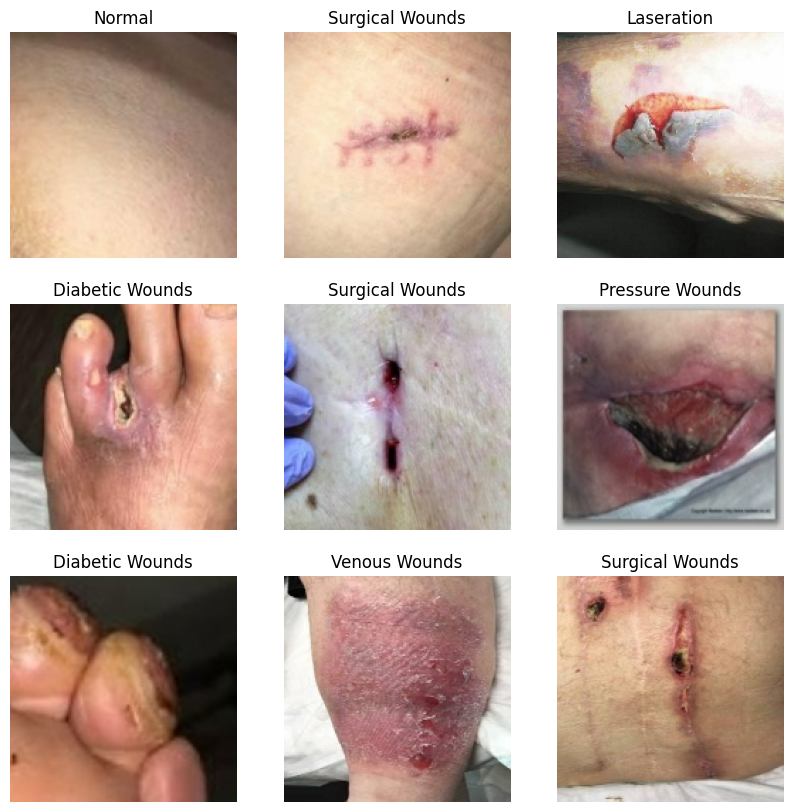

In [11]:
# Tạo một figure mới với kích thước 10x10 inches để hiển thị các hình ảnh
plt.figure(figsize=(10, 10))

# Lấy một batch dữ liệu từ dataset huấn luyện (chỉ lấy 1 batch đầu tiên)
for images, labels in train_dataset.take(1):
    # Lặp qua 9 hình ảnh trong batch để hiển thị
    for i in range(9):
        try:
            # Tạo một subplot 3x3 để hiển thị hình ảnh
            ax = plt.subplot(3, 3, i + 1)
            # Hiển thị hình ảnh với định dạng uint8
            plt.imshow(images[i].numpy().astype("uint8"))
            # Đặt tiêu đề cho subplot với tên lớp tương ứng
            plt.title(class_names[labels[i]])
            # Tắt hiển thị trục
            plt.axis("off")
        except:
            # Nếu có lỗi xảy ra trong quá trình hiển thị hình ảnh, tiếp tục với hình ảnh tiếp theo
            continue

### Xử lý ảnh

In [12]:
# Tự động điều chỉnh kích thước buffer cho prefetch để cải thiện hiệu suất
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Áp dụng prefetching cho dataset huấn luyện để tải dữ liệu trước khi cần, giúp cải thiện hiệu suất
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

# Áp dụng prefetching cho dataset validation để tải dữ liệu trước khi cần, giúp cải thiện hiệu suất
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

# Áp dụng prefetching cho dataset kiểm thử để tải dữ liệu trước khi cần, giúp cải thiện hiệu suất
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [13]:
# Tạo một chuỗi các lớp augmentation dữ liệu để tăng cường dữ liệu hình ảnh
data_augmentation = tf.keras.Sequential([
    # Lật hình ảnh theo cả chiều ngang và chiều dọc một cách ngẫu nhiên
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),

    # Thay đổi độ tương phản của hình ảnh một cách ngẫu nhiên trong khoảng từ 0 đến 1
    tf.keras.layers.RandomContrast(1),

    # Xoay hình ảnh trong khoảng từ -1 đến 0.5 radians
    tf.keras.layers.RandomRotation((-1, 0.5)),

    # Cắt hình ảnh ngẫu nhiên với kích thước 160x160 pixels
    tf.keras.layers.RandomCrop(160, 160),

    # Phóng to hình ảnh ngẫu nhiên với tỷ lệ tối đa là 0.2
    tf.keras.layers.RandomZoom(0.2),
])

## Xây dựng mô hình

### Pretrained

In [14]:
# Lấy hàm preprocess_input từ mô hình MobileNetV2, dùng để chuẩn hóa đầu vào cho mô hình
preprocess_input = tf.keras.applications.mobilenet.preprocess_input

# Chọn kiểu mô hình MobileNetV2 từ thư viện Keras
model_type = tf.keras.applications.MobileNetV2

# Tạo kích thước hình ảnh đầu vào bao gồm 3 kênh màu (RGB)
IMG_SHAPE = IMG_SIZE + (3,)

# Tạo mô hình MobileNetV2 với các tham số cấu hình:
# - input_shape: Kích thước đầu vào của hình ảnh
# - include_top=False: Không bao gồm lớp phân loại cuối cùng của mô hình (để sử dụng mô hình như một extractor đặc trưng)
# - weights='imagenet': Sử dụng trọng số đã được huấn luyện trước trên tập dữ liệu ImageNet
base_model = model_type(input_shape=IMG_SHAPE,
                        include_top=False,
                        weights='imagenet')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [15]:
try:
    # Cố gắng lấy một batch dữ liệu từ train_dataset bằng cách sử dụng hàm iter()
    image_batch, label_batch = iter(train_dataset)
except:
    # Nếu có lỗi xảy ra (ví dụ: nếu iter() không hoạt động), thử lấy một batch dữ liệu bằng cách sử dụng next()
    image_batch, label_batch = next(iter(train_dataset))

# Lấy một batch dữ liệu từ train_dataset
image_batch, label_batch = next(iter(train_dataset))

# Chuyển đổi batch hình ảnh qua mô hình base_model để trích xuất đặc trưng
feature_batch = base_model(image_batch)

# In kích thước của batch đặc trưng
print(feature_batch.shape)

(16, 5, 5, 1280)


In [16]:
# Đặt thuộc tính trainable của base_model thành False
# Điều này ngăn không cho các trọng số của base_model được cập nhật trong quá trình huấn luyện
base_model.trainable = False

# In thông tin tóm tắt về mô hình base_model, bao gồm cấu trúc các lớp và số lượng tham số
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [17]:
# Tạo một lớp GlobalAveragePooling2D
# Lớp này tính trung bình của các đặc trưng theo chiều không gian (chiều cao và chiều rộng)
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# Áp dụng lớp GlobalAveragePooling2D lên batch đặc trưng để giảm kích thước đầu ra
# Tạo ra một vector đặc trưng cho mỗi hình ảnh bằng cách tính trung bình các giá trị đặc trưng
feature_batch_average = global_average_layer(feature_batch)

# In kích thước của batch đặc trưng sau khi áp dụng GlobalAveragePooling2D
print(feature_batch_average.shape)

(16, 1280)


In [18]:
# Tạo một lớp Dense với số lượng đơn vị bằng số lớp (num_classes)
# Lớp này sẽ đưa ra dự đoán cho từng lớp của bài toán phân loại
prediction_layer = tf.keras.layers.Dense(num_classes, name='predict')

# Áp dụng lớp Dense lên batch đặc trưng đã được tính trung bình
# Lớp này tạo ra dự đoán cho từng hình ảnh trong batch
prediction_batch = prediction_layer(feature_batch_average)

# In kích thước của batch dự đoán
print(prediction_batch.shape)

(16, 10)


### Mô hình

In [19]:
# Định nghĩa đầu vào của mô hình với kích thước hình ảnh IMG_SHAPE
inputs = tf.keras.Input(shape=IMG_SHAPE, name='image_tensor')

# Áp dụng các bước augmentation dữ liệu cho đầu vào hình ảnh
x = data_augmentation(inputs)

# Tiền xử lý hình ảnh bằng hàm preprocess_input
x = preprocess_input(x)

# Chuyển đổi hình ảnh qua mô hình base (MobileNetV2) để trích xuất các đặc trưng
# Đặt training=False để đảm bảo các lớp của base_model không được cập nhật trong quá trình huấn luyện
x = base_model(x, training=False)

# Áp dụng lớp GlobalAveragePooling2D để giảm kích thước đặc trưng
x = global_average_layer(x)

# Thêm lớp Dropout để giảm overfitting, với tỷ lệ dropout là 20%
x = tf.keras.layers.Dropout(0.2)(x)

# Áp dụng lớp Dense để tạo ra dự đoán cuối cùng cho từng lớp
outputs = prediction_layer(x)

# Tạo mô hình Keras với đầu vào 'inputs' và đầu ra 'outputs'
# Đặt tên cho mô hình theo biến model_name
model = tf.keras.Model(inputs, outputs, name=model_name)

## Huấn luyện

In [20]:
# Biên dịch mô hình với các tham số sau:
model.compile(
    # Cài đặt optimizer Adam với tốc độ học (learning rate) được chỉ định
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),

    # Chỉ định hàm mất mát SparseCategoricalCrossentropy với từ logits=True
    # Từ logits=True cho biết đầu ra của mô hình chưa được chuyển đổi thành xác suất
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),

    # Theo dõi độ chính xác của mô hình trong quá trình huấn luyện và đánh giá
    metrics=['accuracy']
)

# In thông tin tóm tắt về mô hình, bao gồm cấu trúc các lớp và số lượng tham số
model.summary()

# In số lượng các biến có thể huấn luyện (trainable variables) trong mô hình
print(f"Number of trainable variables: {len(model.trainable_variables)}")

Model: "mobilenet_V2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image_tensor (InputLayer)       │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predict (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Number of trainable variables: 2


In [21]:
# Đánh giá mô hình trên tập dữ liệu validation_dataset
# Trả về giá trị mất mát (loss) và độ chính xác (accuracy) của mô hình
loss0, accuracy0 = model.evaluate(validation_dataset)

# In giá trị mất mát ban đầu (loss) của mô hình trên tập validation
print("initial loss: {:.2f}".format(loss0))

# In độ chính xác ban đầu (accuracy) của mô hình trên tập validation
print("initial accuracy: {:.2f}".format(accuracy0))

37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.0874 - loss: 2.9766
initial loss: 2.96
initial accuracy: 0.08


In [22]:
# Đặt đường dẫn để lưu các checkpoint mô hình
checkpoints_path = path_colab_drive + "/model/checkpoints/Classification_1/checkpoint.weights.h5"

# Tạo một lớp callback tùy chỉnh để thu thập thông tin về các batch trong quá trình huấn luyện
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    # Khởi tạo danh sách để lưu trữ mất mát và độ chính xác của các batch
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    # Lưu trữ giá trị mất mát và độ chính xác của batch hiện tại
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['accuracy'])
    # Đặt lại các số liệu của mô hình sau mỗi batch
    self.model.reset_metrics()

# Khởi tạo callback thu thập thông tin về các batch
batch_stats_callback = CollectBatchStats()

# Tạo một callback để lưu các checkpoint của mô hình
# - Lưu mô hình tốt nhất dựa trên độ chính xác trên tập validation
# - Chỉ lưu trọng số của mô hình (không lưu cấu trúc mô hình)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoints_path, monitor='val_accuracy', verbose=0, save_best_only=True,
    save_weights_only=True, mode='max', save_freq='epoch')

# Tạo một callback để dừng huấn luyện sớm nếu độ chính xác trên tập validation không cải thiện
early_stop_callback = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_accuracy', mode='max')

# Tạo danh sách các callbacks để sử dụng trong quá trình huấn luyện
callbacks = [
    checkpoint_callback,  # Callback để lưu các checkpoint
    early_stop_callback   # Callback để dừng huấn luyện sớm nếu cần
]

In [23]:
# Huấn luyện mô hình với dữ liệu huấn luyện train_dataset
# - Số epoch được chỉ định bởi biến initial_epochs
# - Sử dụng validation_dataset để theo dõi hiệu suất mô hình trên tập dữ liệu validation trong quá trình huấn luyện
# - Áp dụng các callbacks đã được cấu hình để theo dõi và điều chỉnh quá trình huấn luyện
history = model.fit(
    train_dataset,                       # Dataset dùng để huấn luyện mô hình
    epochs=initial_epochs,              # Số lượng epoch để huấn luyện
    validation_data=validation_dataset, # Dataset dùng để kiểm tra mô hình trong quá trình huấn luyện
    callbacks=callbacks                 # Danh sách các callback để theo dõi và điều chỉnh quá trình huấn luyện
)

Epoch 1/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.3325 - loss: 2.0622 - val_accuracy: 0.5685 - val_loss: 1.1754
Epoch 2/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.5910 - loss: 1.1346 - val_accuracy: 0.6261 - val_loss: 1.0734
Epoch 3/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.6668 - loss: 0.9596 - val_accuracy: 0.6464 - val_loss: 1.0426
Epoch 4/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - accuracy: 0.6812 - loss: 0.8571 - val_accuracy: 0.6751 - val_loss: 0.9630
Epoch 5/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - accuracy: 0.7134 - loss: 0.8222 - val_accuracy: 0.6717 - val_loss: 0.9182
Epoch 6/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.7197 - loss: 0.7738 - val_accuracy: 0.6701 - val_loss: 0.9246
Epoch 7/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.7214 - loss: 0.7669 - val_accuracy: 0.7022 - val_loss: 0.8862
Epoch 8/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.7500 - loss: 0.7035

In [24]:
# Tìm giá trị độ chính xác cao nhất đạt được trên tập validation trong quá trình huấn luyện
accurary = max(history.history['val_accuracy'])

# In ra giá trị độ chính xác cao nhất
print("Độ chính xác: ", accurary)

Độ chính xác:  0.7546531558036804


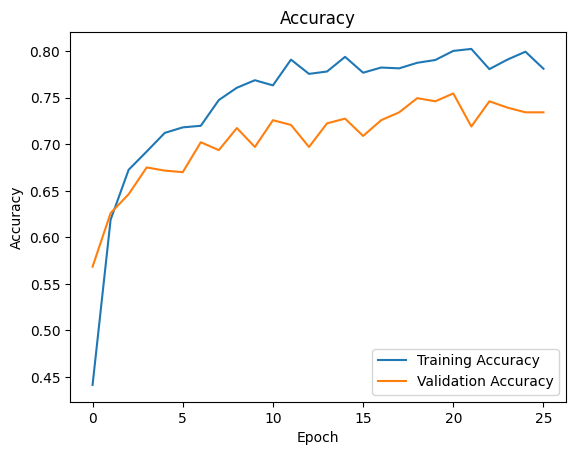

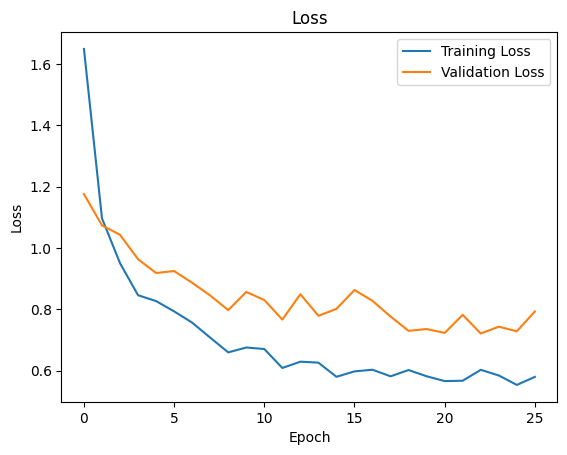

In [25]:
# Lấy các giá trị độ chính xác và mất mát từ lịch sử huấn luyện mô hình
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Vẽ biểu đồ độ chính xác
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Vẽ biểu đồ mất mát
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()


### Lưu mô hình

In [29]:
# Lưu dưới định dạng .keras (chuẩn mới của Keras)
model.save(f"{path_colab_drive}/model/model_class.keras", include_optimizer=True)

# Lưu thêm dưới định dạng .h5 (chuẩn cũ, nhiều thư viện vẫn dùng)
model.save(f"{path_colab_drive}/model/model_class.h5",
           include_optimizer=True,
           save_format="h5")

# Dự đoán

In [36]:
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

# Đường dẫn đến mô hình đã lưu
model_path = f'{path_colab_drive}/model/model_class_part_1.keras'

def predict_class_img_with_img(img_path):
    # Danh sách tên các lớp (10 class)
    class_names = [
        'Abrasions', 'Bruises', 'Burns', 'Cut',
        'Diabetic Wounds', 'Laseration', 'Normal',
        'Pressure Wounds', 'Surgical Wounds', 'Venous Wounds'
    ]

    # Load mô hình
    model = load_model(model_path)

    # Đọc ảnh và đổi sang RGB
    img_arr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)

    # Resize về (160,160)
    image = cv2.resize(img_rgb, (160, 160))
    input_img = np.expand_dims(image, axis=0)  # shape (1,160,160,3)

    # Dự đoán lớp
    predictions = model.predict(input_img)
    scores = tf.nn.softmax(predictions[0]).numpy()
    pred_label = np.argmax(scores)

    # In kết quả
    print(f"Kết quả dự đoán: {class_names[pred_label]}, Độ tin cậy: {scores[pred_label] * 100:.2f}%")

    # Hiển thị bằng matplotlib
    plt.imshow(image)
    plt.title(f"Predicted: {class_names[pred_label]} ({scores[pred_label]*100:.2f}%)")
    plt.axis("off")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Kết quả dự đoán: Bruises, Độ tin cậy: 99.66%


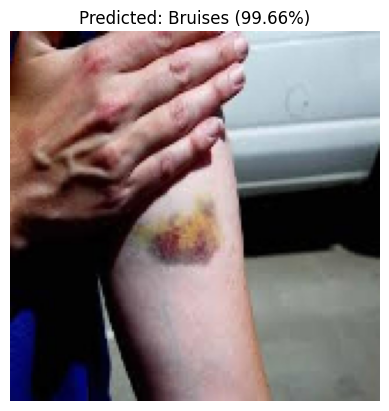

In [37]:
img_path = '/content/data/test/Bruises/bruises (113).jpg'
predict_class_img_with_img(img_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Kết quả dự đoán: Cut, Độ tin cậy: 97.35%


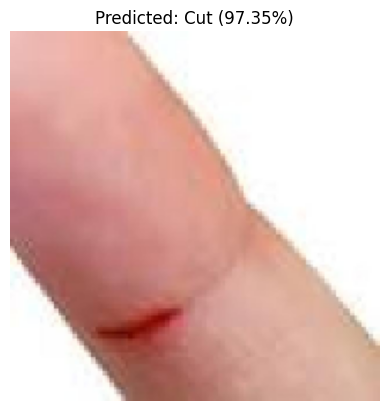

In [38]:
img_path = '/content/data/test/Cut/cut (14).jpg'
predict_class_img_with_img(img_path)